<a href="https://colab.research.google.com/github/Bassie1/notebooks/blob/main/June_21_current.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --trusted-host files.pythonhosted.org --trusted-host pypi.org pytorch-forecasting

In [ ]:

import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

#os.chdir("../../..")


In [ ]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
#from pytorch_forecasting import pytorch_lightning as pl
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.encoders import NaNLabelEncoder

In [ ]:
torch. __version__

'1.9.0+cu102'

In [ ]:
pl. __version__

'1.3.3'

In [ ]:
products4 = pd.read_csv('merged_grouped_by_date')
#products4=products4orig.copy()

In [ ]:
products4.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807584 entries, 0 to 807583
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        807584 non-null  int64  
 1   asin              807584 non-null  object 
 2   date              807584 non-null  object 
 3   sales             807584 non-null  float64
 4   count_new         807584 non-null  float64
 5   buy_box_shipping  807584 non-null  float64
 6   time_idx          807584 non-null  float64
 7   sales_rank        807584 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 49.3+ MB


In [ ]:
products4=products4.drop(['Unnamed: 0', 'sales_rank'], axis=1) 
products4=products4.rename(columns={'sales':'sales_rank'})

In [ ]:
products4.isnull().sum()

asin                0
date                0
sales_rank          0
count_new           0
buy_box_shipping    0
time_idx            0
dtype: int64

In [ ]:

products4['date'] =  pd.to_datetime(products4['date'], infer_datetime_format=True)
products4['date'].head()

0   2020-06-19
1   2020-06-23
2   2020-07-03
3   2020-07-06
4   2020-07-09
Name: date, dtype: datetime64[ns]

In [ ]:
# add additional features
# categories have to be strings
products4["month"] = products4['date'].dt.month.astype(str).astype("category")

Leaving for future work: Could use price to add in these features - group by product and year/quarter/time index, transform on mean, mode, or min (how 14 or 50?) 
Current ROI Avg ROI,(90D) Avg ROI , (year) Most common ROI (year), Lowest ROI (14 for 90), Lowest ROI (50 for 365)
products4["avg_price_by_product"] = (
    data
    .groupby(["time_idx", "name"], observed=True)
    .volume.transform("mean")
)
d["avg_volume_by_agency"] = (
    data
    .groupby(["time_idx", "agency"], observed=True)
    .volume.transform("mean")
)

In [ ]:
products4.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807584 entries, 0 to 807583
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   asin              807584 non-null  object        
 1   date              807584 non-null  datetime64[ns]
 2   sales_rank        807584 non-null  float64       
 3   count_new         807584 non-null  float64       
 4   buy_box_shipping  807584 non-null  float64       
 5   time_idx          807584 non-null  float64       
 6   month             807584 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(4), object(1)
memory usage: 37.7+ MB


In [ ]:

products4['asin']=products4['asin'].astype('str')
#products4['month']=products4['month'].astype('str')

In [ ]:
len(products4['asin'].unique())

22110

In [ ]:
#pd.set_option('max_rows',1000)

In [ ]:
count=0
full_time_set = set([0,1,2,3,4,5,6,7,8,9,10,11,12])
asin_list=[]
for asin in products4['asin'].unique().tolist():
    one_asin_df = products4[products4['asin']==asin]
    time_idx_set = set(one_asin_df['time_idx'].tolist())
    if full_time_set.issubset(time_idx_set):
        asin_list.append(asin)
   

In [ ]:
len(asin_list)

2739

In [ ]:
products4['time_idx']=products4['time_idx'].astype('int8')
products4.head()

,asin,date,sales_rank,count_new,buy_box_shipping,time_idx,month
0,0805470859,2020-06-19,9201.750000,8.0,18.98,0,6
1,0805470859,2020-06-23,11465.666667,9.0,18.98,0,6
2,0805470859,2020-07-03,10141.714286,4.0,18.98,1,7
3,0805470859,2020-07-06,9467.500000,5.0,18.98,1,7
4,0805470859,2020-07-09,8317.300000,6.0,18.98,1,7


In [ ]:
fullproducts=products4[products4['asin'].isin(asin_list)]


products4.loc[(products4['time_idx']==0) | (products4['time_idx']==1)| (products4['time_idx']==2),'quarter']=1
products4.loc[(products4['time_idx']==3) | (products4['time_idx']==4)| (products4['time_idx']==5),'quarter']=2
products4.loc[(products4['time_idx']==6) | (products4['time_idx']==7)| (products4['time_idx']==8),'quarter']=3
products4.loc[(products4['time_idx']==9) | (products4['time_idx']==10)| (products4['time_idx']==11),'quarter']=4

products4 = products4[['type','name','asin','month','time_idx', 'new','sales_rank','count_new','buy_box_shipping']]
products4["type"] = products4['type'].astype("category")
products4["name"] = products4['name'].astype("category")
products4["asin"] = products4['asin'].astype("category")
products4["time_idx"] = products4['time_idx'].astype("int8")
products4["count_new"] = products4['count_new'].astype("float16")
products4['new'] = products4['new'].astype("float16")
products4['sales_rank'] = products4['sales_rank'].astype("float16")
products4['buy_box_shipping'] = products4['buy_box_shipping'].astype("float16")
#nonnull_products = products4.groupby(['type','name','asin','month','time_idx']).mean().reset_index().dropna(axis=0)
#nonnull_products

nonnull_products = products4.groupby(['type','name','asin','month','time_idx']).mean().reset_index().dropna(axis=0)
nonnull_products

from pytorch_forecasting.data import (
    TimeSeriesDataSet,
    GroupNormalizer
)
df=products4
max_prediction_length =  1 # changing to a forecst of 3 months, which is 90 days,from a forecast 6 months
max_encoder_length = 3  # using 12 months, which is 360 DAYS, instead of  24 months of history
training_cutoff =df["quarter"].max() - max_prediction_length
#print(training_cutoff)
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    allow_missings=True,
    #categorical_encoders={'asin': NaNLabelEncoder(add_nan=True)},
    categorical_encoders={'month': NaNLabelEncoder(add_nan=True), 'asin': NaNLabelEncoder(add_nan=True)},
    time_idx="quarter",
    target="buy_box_shipping",
    group_ids=["asin"],
    #min_encoder_length=0,  # allow predictions without history
    min_encoder_length=max_encoder_length // 2, # time series have a minimum length of 13 (min_prediction_length + min_encoder_length)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["asin"],
    time_varying_known_categoricals=['month'],
    time_varying_known_reals=[
        "time_idx",
        "quarter",
        "sales_rank",
        'count_new'
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'buy_box_shipping',
    ],
    target_normalizer=GroupNormalizer(
        groups=["asin"], transformation='softplus'
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,  # add as feature
    add_target_scales=True,  # add as feature
    add_encoder_length=True,  # add as feature
    
)
# create validation set (predict=True) which means to predict the
# last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(
    training, df, predict=True, stop_randomization=True
)
# create dataloaders for model
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from pytorch_forecasting.data import (
    TimeSeriesDataSet,
    GroupNormalizer
)
df=fullproducts
max_prediction_length =  3 # changing to a forecst of 3 months, which is 90 days,from a forecast 6 months
max_encoder_length = 10  # using 12 months, which is 360 DAYS, instead of  24 months of history
training_cutoff =df["time_idx"].max() - max_prediction_length
#print(training_cutoff)
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    allow_missings=True,
    #categorical_encoders={'asin': NaNLabelEncoder(add_nan=True)},
    categorical_encoders={'month': NaNLabelEncoder(add_nan=True), 'asin': NaNLabelEncoder(add_nan=True)},
    time_idx="time_idx",
    target="buy_box_shipping",
    group_ids=["asin"],
    #min_encoder_length=0,  # allow predictions without history
    min_encoder_length=max_encoder_length // 2, # time series have a minimum length of 13 (min_prediction_length + min_encoder_length)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["asin"],
    time_varying_known_categoricals=['month'],
    time_varying_known_reals=[
        "time_idx",
        "sales_rank",
        'count_new'
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'buy_box_shipping',
    ],
    target_normalizer=GroupNormalizer(
        groups=["asin"], transformation='softplus'
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,  # add as feature
    add_target_scales=True,  # add as feature
    add_encoder_length=True,  # add as feature
    
)
# create validation set (predict=True) which means to predict the
# last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(
    training, df, predict=True, stop_randomization=True
)
# create dataloaders for model
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0, drop_last=True
)

In [ ]:
df.head()

,asin,date,sales_rank,count_new,buy_box_shipping,time_idx,month
284,B0000AA8UL,2020-06-21,5338.000000,7.0,26.30,0,6
285,B0000AA8UL,2020-06-25,5540.250000,8.5,26.10,0,6
286,B0000AA8UL,2020-06-26,5309.666667,10.0,26.30,0,6
287,B0000AA8UL,2020-06-27,5450.000000,9.0,26.10,0,6
288,B0000AA8UL,2020-07-16,6406.500000,8.5,26.81,1,7


In [ ]:
df[df['asin']=='B0000AA8UL'].nunique()

asin                  1
date                133
sales_rank          133
count_new            31
buy_box_shipping     91
time_idx             13
month                12
dtype: int64

#training.from_dataset(training, products4)
#training.plot_randomization()
#3training.x_to_index()

convert the dataset to a dataloader
#dataloader = dataset.to_dataloader(batch_size=4)

and load the first batch
x, y = next(iter(train_dataloader))
print("x =", x)
print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

1.247198224067688

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=0,
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 65.7k


In [ ]:
tft.size()

65737


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 43.9 K
3  | prescalers                         | ModuleDict                      | 128   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.6 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Restored states from the checkpoint file at C:\Users\chaya\Documents\incube88\incube_prediction\lr_find_temp_model.ckpt


suggested learning rate: 9.549925860214362e-06


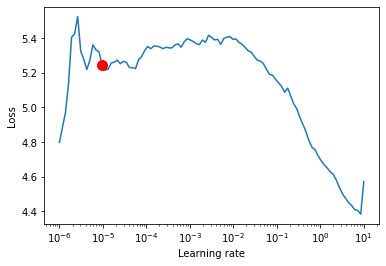

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top", #can change to "full"
    gradient_clip_val=0.1,
    #limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,#suggested learning rate: 0.10964781961431845 but did not enter because on the tutorial, suggested learning rate: 0.06 but left .03 because For the TemporalFusionTransformer, the optimal learning rate seems to be slightly lower than the suggested one and sometimes noise causes it to suggest too low ones.
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    #output_size=4,  # 7 quantiles by default
    loss=QuantileLoss(),
    #log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
    log_interval=0 #added because of histogram error "hacky solution" github issue 376
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 65.7k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)
    

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 43.9 K
3  | prescalers                         | ModuleDict                      | 128   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.6 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Global seed set to 42


In [ ]:
###LONG RUNNING CELL - BEWARE!!
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    #n_trials = 10 # after 22 trials, the first was the best, and a lot were pruned, so I stopped the cell - the first took 15 minutes, the pruned two minutes
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,
    # use Optuna to find ideal learning rate or use in-built learning rate finder
)



[I 2021-06-21 09:40:48,699] A new study created in memory with name: no-name-2e858fda-3958-4c3e-b4c7-835e0baa6532
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42
[I 2021-06-21 09:51:42,958] Trial 0 finished with value: 2.5382626056671143 and parameters: {'gradient_clip_val': 0.04565126507368562, 'hidden_size': 13, 'dropout': 0.11846221789787781, 'hidden_continuous_size': 9, 'attention_head_size': 3, 'learning_rate': 0.0023719645503948636}. Best is trial 0 with value: 2.5382626056671143.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42
[I 2021-06-21 09:59:49,890] Trial 1 finished with value: 0.8815973401069641 and parameters: {'gradient_clip_val': 0.047608874838619676, 'hidden_size': 9, 'dropout': 0.11270253515891676, 'hidden_continuous_size': 9, 'attention_head_size': 1, 'learning_rate': 0.03590564003310757}. Be

RuntimeError: CUDA out of memory. Tried to allocate 228.00 MiB (GPU 0; 6.00 GiB total capacity; 1.39 GiB already allocated; 94.90 MiB free; 2.00 GiB reserved in total by PyTorch)

In [ ]:
# save study results - also we can resume tuning at a later point in time
with open("test_study_full3.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

In [ ]:
# #code to save the trainer and tft
torch.save(trainer, "trainer2")
torch.save(tft, "tft2")

# #code to read back in the saved files
# tft1 = torch.load('tft')
# trainer1 = torch.load("trainer")

In [ ]:
# import pickle
# #code that pickles tft
# with open("tft2.pkl", "wb") as fout:
#     pickle.dump(tft, fout)
    
# #code that pickes the trainer
# with open("trainer2.pkl", "wb") as fout:
#     pickle.dump(trainer, fout)



In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calculate mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader, show_progress_bar=True)
(actuals - predictions).abs().mean()

tensor(1.8668)

In [ ]:
# calculate mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader, show_progress_bar=True)
#pr, x_pr, idx = best_model.predict(data_ts, mode="prediction", return_x=True, return_index=True)
predictions, x, idx = best_tft.predict(val_dataloader, mode='prediction', show_progress_bar=True, return_x=True, return_index=True)
(actuals - predictions).abs().mean()

tensor(1.8668)

In [ ]:
# make predictions
#res, index = tft.predict(validation, return_index=True)

# turn predictions into dataframe: time_idx is at horizon=0 (first prediction)
df_pred_before = pd.DataFrame(predictions.numpy(), index=pd.MultiIndex.from_frame(idx), columns=pd.RangeIndex(0, predictions.size(1), name="horizon"))

# change time_idx to correspond to each prediction
df_pred = (
    df_pred_before
    .stack()
    .reset_index(["time_idx", "horizon"])
    .assign(time_idx=lambda x: x.time_idx + x.horizon - 1)
    .set_index(["time_idx", "horizon"], append=True)[0]
    .unstack("horizon")
    .add_prefix("prediction_at_horizon_")
)

# add predictions to original dataframe
original_df_with_predictions = df.join(df_pred, on=df_pred.index.names)


In [ ]:
df_pred.index.names

FrozenList(['asin', 'time_idx'])

In [ ]:
df_pred_before

,horizon,0,1,2
time_idx,asin,,,
124,B0000AA8UL,26.447807,26.483265,26.821327
92,B0000AE5ZB,6.036460,6.186304,6.176657
87,B0000CDBQT,16.187349,16.613964,15.048189
48,B0000D17HA,7.172143,7.167417,7.039149
114,B0000DID5R,7.948804,7.959357,7.977764
...,...,...,...,...
53,B07RX3FCV7,6.586874,6.682983,6.992352
143,B07RYNJZYW,22.417355,22.807953,22.598183
108,B07RZ2TTN1,22.668793,22.415962,22.442623


In [ ]:
df.to_csv('fullproducts.csv')

In [ ]:
df_pred

horizon              prediction_at_horizon_0  prediction_at_horizon_1  \
asin       time_idx                                                     
B0000AA8UL 123                     26.447807                      NaN   
           124                           NaN                26.483265   
           125                           NaN                      NaN   
B0000AE5ZB 91                       6.036460                      NaN   
           92                            NaN                 6.186304   
...                                      ...                      ...   
B07RZ3NX7J 76                            NaN                21.304327   
           77                            NaN                      NaN   
B07S6Z9X5B 84                      26.195789                      NaN   
           85                            NaN                25.729805   
           86                            NaN                      NaN   

horizon              prediction_at_horizon_2  
asin       time_idx                           
B0000AA8UL 123                           NaN  
           124                           NaN  
           125                     26.821327  
B0000AE5ZB 91                            NaN  
           92                            NaN  
...                                      ...  
B07RZ3NX7J 76                            NaN  
           77                      21.310368  
B07S6Z9X5B 84                            NaN  
           85                            NaN  
           86                      26.178699  

[7680 rows x 3 columns]

In [ ]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7680 entries, ('B0000AA8UL', 123) to ('B07S6Z9X5B', 86)
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   prediction_at_horizon_0  2560 non-null   float32
 1   prediction_at_horizon_1  2560 non-null   float32
 2   prediction_at_horizon_2  2560 non-null   float32
dtypes: float32(3)
memory usage: 232.6+ KB


In [ ]:
original_df_with_predictions

,asin,date,sales_rank,count_new,buy_box_shipping,time_idx,month,prediction_at_horizon_0,prediction_at_horizon_1,prediction_at_horizon_2
284,B0000AA8UL,2020-06-21,5338.000000,7.0,26.30,0,6,NaN,NaN,NaN
285,B0000AA8UL,2020-06-25,5540.250000,8.5,26.10,0,6,NaN,NaN,NaN
286,B0000AA8UL,2020-06-26,5309.666667,10.0,26.30,0,6,NaN,NaN,NaN
287,B0000AA8UL,2020-06-27,5450.000000,9.0,26.10,0,6,NaN,NaN,NaN
288,B0000AA8UL,2020-07-16,6406.500000,8.5,26.81,1,7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
782963,B08B5L46HD,2021-05-30,15422.500000,9.0,18.47,11,5,NaN,NaN,NaN
782964,B08B5L46HD,2021-06-01,11379.375000,10.5,18.45,12,6,NaN,NaN,NaN
782965,B08B5L46HD,2021-06-03,11204.200000,10.0,18.16,12,6,NaN,NaN,NaN
782966,B08B5L46HD,2021-06-04,11921.125000,9.5,18.45,12,6,NaN,NaN,NaN


In [ ]:
original_df_with_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346509 entries, 284 to 782967
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   asin                     346509 non-null  object        
 1   date                     346509 non-null  datetime64[ns]
 2   sales_rank               346509 non-null  float64       
 3   count_new                346509 non-null  float64       
 4   buy_box_shipping         346509 non-null  float64       
 5   time_idx                 346509 non-null  int8          
 6   month                    346509 non-null  category      
 7   prediction_at_horizon_0  0 non-null       float32       
 8   prediction_at_horizon_1  0 non-null       float32       
 9   prediction_at_horizon_2  0 non-null       float32       
dtypes: category(1), datetime64[ns](1), float32(3), float64(3), int8(1), object(1)
memory usage: 30.5+ MB


In [ ]:
prediction_df=pd.DataFrame()
prediction_df["prediction"] = predictions[:, 0]
prediction_df


,prediction
0,26.447807
1,6.036460
2,16.187349
3,7.172143
4,7.948804
...,...
2555,6.586874
2556,22.417355
2557,22.668793
2558,21.848070


In [ ]:
predictions

tensor([[26.4478, 26.4833, 26.8213],
        [ 6.0365,  6.1863,  6.1767],
        [16.1873, 16.6140, 15.0482],
        ...,
        [22.6688, 22.4160, 22.4426],
        [21.8481, 21.3043, 21.3104],
        [26.1958, 25.7298, 26.1787]])

In [ ]:
predictions.shape

torch.Size([2560, 3])

In [ ]:
idx

,time_idx,asin
0,124,B0000AA8UL
1,92,B0000AE5ZB
2,87,B0000CDBQT
3,48,B0000D17HA
4,114,B0000DID5R
...,...,...
2555,53,B07RX3FCV7
2556,143,B07RYNJZYW
2557,108,B07RZ2TTN1
2558,76,B07RZ3NX7J


In [ ]:
x

{'encoder_cat': tensor([[[1.0000e+00, 7.0000e+00],
          [1.0000e+00, 7.0000e+00],
          [1.0000e+00, 7.0000e+00],
          ...,
          [       nan,        nan],
          [       nan,        nan],
          [       nan,        nan]],
 
         [[2.0000e+00, 7.0000e+00],
          [2.0000e+00, 7.0000e+00],
          [2.0000e+00, 7.0000e+00],
          ...,
          [       nan,        nan],
          [       nan,        nan],
          [       nan,        nan]],
 
         [[3.0000e+00, 7.0000e+00],
          [3.0000e+00, 7.0000e+00],
          [3.0000e+00, 7.0000e+00],
          ...,
          [       nan,        nan],
          [       nan,        nan],
          [       nan,        nan]],
 
         ...,
 
         [[2.5580e+03, 7.0000e+00],
          [2.5580e+03, 7.0000e+00],
          [2.5580e+03, 7.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]],
 
         [[2.5590e+03, 7.0000e+00

In [ ]:
#raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True, show_progress_bar=True)


In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);


In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );


In [ ]:
#predictions
#mean_losses
indices

In [ ]:
predictions

In [ ]:
mean_losses

In [ ]:

predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [ ]:
best_tft.predict(
    training.filter(lambda x: (x.asin == 'B0000AA8UL')  & (x.time_idx_first_prediction == 9)),
    mode="quantiles",
)

tensor([[[25.5603, 27.0802, 28.0129, 28.8257, 29.7332, 30.7322, 32.6567],
         [24.5800, 26.4464, 27.5406, 28.4305, 29.3895, 30.4814, 32.6389],
         [24.6447, 26.2739, 27.2250, 27.9917, 28.8193, 29.7530, 31.6165]],

        [[25.5586, 27.0796, 28.0127, 28.8259, 29.7339, 30.7336, 32.6593],
         [24.5778, 26.4455, 27.5403, 28.4307, 29.3902, 30.4827, 32.6417],
         [24.6434, 26.2733, 27.2248, 27.9918, 28.8197, 29.7537, 31.6180]],

        [[25.5540, 27.0780, 28.0122, 28.8267, 29.7359, 30.7375, 32.6661],
         [24.5719, 26.4431, 27.5397, 28.4315, 29.3920, 30.4862, 32.6491],
         [24.6401, 26.2719, 27.2244, 27.9922, 28.8207, 29.7557, 31.6220]],

        [[25.5686, 27.0832, 28.0139, 28.8244, 29.7297, 30.7254, 32.6446],
         [24.5908, 26.4509, 27.5417, 28.4292, 29.3863, 30.4750, 32.6253],
         [24.6512, 26.2767, 27.2260, 27.9912, 28.8175, 29.7494, 31.6091]],

        [[25.5682, 27.0830, 28.0138, 28.8244, 29.7299, 30.7257, 32.6451],
         [24.5903, 26.4507, 27

RuntimeError: index 36 is out of bounds for dimension 0 with size 11

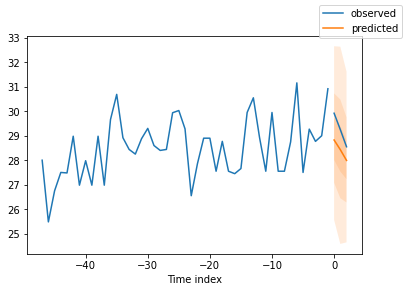

In [ ]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.asin == "B0000AA8UL")  & (x.time_idx_first_prediction == 9)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);


In [ ]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = df[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = df[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [ ]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);